# 프로젝트명 : 한국어 데이터로 챗봇 만들기

트랜스포머 모델을 기반으로한 한국어 챗봇을 제작해본다.

## 루브릭

|No.|평가문항|상세기준|
|:---|:---|:---|
|1|한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2|트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3|한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

-------------------------------------

## 1. 데이터 불러오기

In [45]:
# 필요한 패키지 불러오기
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
data_path = os.getenv('HOME') + '/aiffel/exploration/E15/data/ChatbotData .csv'
data = pd.read_csv(data_path)
data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [47]:
# 전체 데이터의 크기
data.shape

(11823, 3)

In [48]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

## 2. 데이터 전처리

데이터에 불필요한 것들을 제거하여 단어 토크나이징(tokenizing)에 방해가 되지 않도록 합니다.

In [68]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  # 공백제거
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (한글, a-z, A-Z, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [69]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))

    return inputs, outputs

In [70]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [72]:
print('전처리 후의 10번째까지 질문 샘플: {}'.format(questions[:10]))
print('전처리 후의 10번째까지 답변 샘플: {}'.format(answers[:10]))

전처리 후의 10번째까지 질문 샘플: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네', 'sd카드 망가졌어', 'sd카드 안돼', 'sns 맞팔 왜 안하지', 'sns 시간낭비인 거 아는데 매일 하는 중', 'sns 시간낭비인데 자꾸 보게됨']
전처리 후의 10번째까지 답변 샘플: ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .', '다시 새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .']


## 3. 병렬 데이터 전처리 하기

### 단어장 만들기

In [73]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [74]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [75]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


In [76]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [77]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]


In [78]:
# 질문과 답변의 길이 살펴보기
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9378330373001775
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716146494121627


In [79]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 16
print(MAX_LENGTH)

16


In [80]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 16 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 16으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [81]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11676
필터링 후의 답변 샘플 개수: 11676


### 교사 강요(Teacher Forcing) 사용하기

훈련 과정에서도 이전 시점의 출력을 다음 시점의 입력으로 사용하면서 훈련 시킬 수도 있지만 이는 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되기 때문에 교사 강요를 사용해줍니다.

In [82]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성

### 포지셔널 인코딩 레이어

문장의 단어를 1개씩 순차적으로 입력 받는 RNN과 달리 __트랜스포머__는 문장에 있는 모든 단어들을 __한꺼번에 입력으로 받기__ 때문에 단어의 임베딩 벡터에다가 __위치정보를 가진 벡터(Positional Encoding)__ 값을 더해서 사용한다.

![img1](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_4_fuzN6PD.png)

포지셔널 인코딩 레이어에서 벡터 값은 사인 함수와 코사인 함수의 값을 이용하여 계산하고 이 값을 임베팅 벡터에 더해주면 순서 정보가 보존되게 되는 것 입니다.

![img2](https://wikidocs.net/images/page/31379/transformer6_final.PNG)

In [86]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 어텐션

어텐션은 __단어들 간의 유사도를 구하는 메커니즘__으로 트랜스포머에서는 다음과 같이 세 가지 어텐션을 사용합니다.

1. __인코더 셀프 어텐션__ : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구함
2. __디코더 셀프 어텐션__ : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과 유사도를 구함
3. __인코더-디코더 어텐션__ : 디코더가 예측을 잘하기 위해 인코더에 입력된 단어들과 유사도를 구함

![img3](https://wikidocs.net/images/page/31379/attention.PNG)

아래와 같이 트랜스포머 아키텍처에서 실제로 각 어텐션이 어디에서 동작하는지 확인할 수 있습니다.

![img4](https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG)

### 스케일드 닷 프로덕트 어텐션

내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q(쿼리)와 K(키)의 유사도를 구하는 방법을 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 합니다.

In [87]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 멀티-헤드 어텐션

병렬로 수행되는 어텐션은 서로 다른 셀프 어텐션 결과를 얻을 수 있습니다. 즉, 병력적으로 어텐션을 수행하면 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있습니다.

In [88]:
# 병렬적으로 어텐션을 수행하기 위한 멀티-헤드 어텐션 함수
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 마스킹
마스킹 작업을 통해 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법을 사용합니다.

#### 패딩 마스킹
패딩 마스킹은 패딩을 통한 전처리 작업 후 채워진 숫자 0이 실제 의미가 있는 단어가 아니므로 숫자 0의 위치를 체크해 어텐션 연산 시에 불필요하게 숫자 0을 참고하지 않게 할 수 있습니다.

![img5](https://d3s0tskafalll9.cloudfront.net/media/images/1365906-20200410103623697-871078599.max-800x600.png)

In [89]:
# 패딩 마스킹(padding masking)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### 룩 어헤드 마스킹
트랜스포머는 전체 문장이 문장 행렬로 들어가기 때문에 위치와 관계없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 하지만 우리가 필요한 것은 직전 단어에서 다음 단어를 제대로 예측하는 것이기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 룩 어헤드 마스킹 방법이 필요합니다.

![img5](https://d3s0tskafalll9.cloudfront.net/media/images/_.max-800x600.png)

In [90]:
# 룩 어헤드 마스킹(look-ahead maksing, 다음 단어 가리기)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 인코더
트랜스포머에서 인코더를 하나의 층이라는 개념으로 생각하면, 하나의 인코더 층에는 아래와 같이 셀프 어텐션과 피드 워드 신경망의 2개의 서브층으로 나눠집니다.

![img7](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_21_Y7Cy8sm.max-800x600.png)  
[출처] : http://jalammar.github.io/illustrated-transformer/%5D

In [91]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행(셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # 두번째 서브 레이어 : 2개의 완결연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완결 연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

트랜스포머에서는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다

In [95]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

슝=3


### 디코더

디코더 층은 아래와 같이 셀프 어텐션, 인코더-디코더 어텐션, 피드 포워드 신경망으로 구성 됩니다.

![img8](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_23_vBHZ3i0.max-800x600.png)  
[출처] : http://jalammar.github.io/illustrated-transformer/

In [96]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

인코더와 동일하기 num_layers 개수의 디코더 층을 쌓게 됩니다.

In [97]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 트랜스포머 모델 구현

In [98]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 생성

In [99]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실함수

In [100]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 된 학습률(Leraning rate)

In [101]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

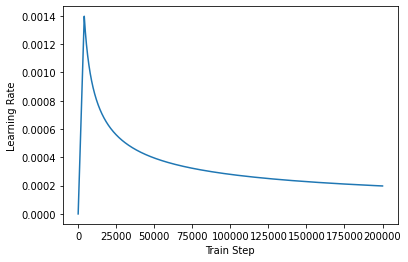

In [102]:
# 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [103]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 훈련하기

In [104]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
183/183 [==============================] - 19s 65ms/step - loss: 3.8829 - accuracy: 0.0326
Epoch 2/20
183/183 [==============================] - 12s 64ms/step - loss: 3.1746 - accuracy: 0.1269
Epoch 3/20
183/183 [==============================] - 12s 64ms/step - loss: 2.6224 - accuracy: 0.1306
Epoch 4/20
183/183 [==============================] - 12s 64ms/step - loss: 2.3961 - accuracy: 0.1382
Epoch 5/20
183/183 [==============================] - 12s 64ms/step - loss: 2.2331 - accuracy: 0.1484
Epoch 6/20
183/183 [==============================] - 12s 64ms/step - loss: 2.0756 - accuracy: 0.1581
Epoch 7/20
183/183 [==============================] - 12s 64ms/step - loss: 1.8979 - accuracy: 0.1730
Epoch 8/20
183/183 [==============================] - 12s 63ms/step - loss: 1.7317 - accuracy: 0.1948
Epoch 9/20
183/183 [==============================] - 12s 63ms/step - loss: 1.5282 - accuracy: 0.2159
Epoch 10/20
183/183 [==============================] - 12s 64ms/step - loss: 1.314

# 5. 모델 평가하기

In [120]:
# decoder_inference() 함수
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [106]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

## 챗봇 테스트 하기

In [107]:
sentence_generation('배고파')

입력 : 배고파
출력 : 맛난 거 드세요 .


'맛난 거 드세요 .'

In [108]:
sentence_generation('저녁에 뭐할까?')

입력 : 저녁에 뭐할까?
출력 : 한 번만 더 연락해보는 건 어떨까요 .


'한 번만 더 연락해보는 건 어떨까요 .'

In [109]:
sentence_generation('가장 어려운게 뭐야?')

입력 : 가장 어려운게 뭐야?
출력 : 마음이라도 어리게 사세요 .


'마음이라도 어리게 사세요 .'

In [110]:
sentence_generation('심심해')

입력 : 심심해
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [116]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [114]:
sentence_generation('오늘 축구 경기 결과 알려줄래?')

입력 : 오늘 축구 경기 결과 알려줄래?
출력 : 현실이라는 벽에 부딪혔군요 .


'현실이라는 벽에 부딪혔군요 .'

테스트 결과를 확인해보니 간단한 질문에는 비교적 정확한 답변을 제공하는 것을 볼 수 있다.
하지만 문장이 조금만 복잡해지면 동문서답을 하는 경우도 있으나 문법적으로 틀리지는 않는다. 

# 회고

- 우선 트랜스포머 모델이 최근에 굉장히 핫한 대한 얘기는 많이 들어봤는데 실제로 접한 것은 처음인지라 초반에는 모델의 아키텍처를 이해하기가 어려웠었다.  
  
  
- 그렇지만 노드에 대한 설명이 친절하게 되어 있어서 기존에 배웠던 인코더/디코더 개념부터 차근 차근 복습을 할 수 있었고, 실습 노드 부분과 프로젝트 부분을 반복적으로 살펴보니 트랜스포머 모델이 기존의 RNN, LSTM과 어떤 점이 다르고 어떤 특징을 가지고 있는지 이해할 수 있게 되었다. 그렇지만 이런 과정을 텐서플로우를 활용해 코드로 구현하는 부분에 대한 것은 추후 기회가 되면 심층적인 스터디가 필요할 것 같다.
  

- 과정 자체가 쉽지는 않았지만 기존에 공부했던 작사가 인공지능 만들기, 영화리뷰 텍스트 분석, 뉴스 요약봇 만들기에 비해 결과물이 좋게 나온 것 같다. 다시 한 번 텐서플로우나 파이토치 같은 라이브러리를 통한 코드 구현에 위대함을 느낀다.

### 참고 문헌 : [딥러닝을 이용한 자연어 처리 입문 - 트랜스포머(유원준)](https://wikidocs.net/31379)